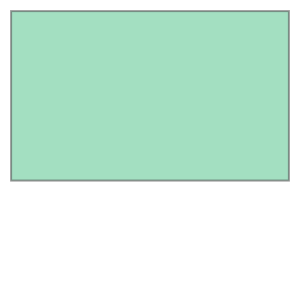

In [5]:
import earthpy.spatial as es
import numpy as np
import os, sys
import geopandas as gpd
import rasterio as rio
from shapely.geometry import box
from glob import glob
from tqdm import tqdm

# Set target_shapefile to the appropriate coordinates
# Create a box from the total_bounds of the shapefile
target_shapefile = gpd.read_file("singapore_boundary.geojson")
target_shapefile = target_shapefile.to_crs("EPSG:32648")
xmin, ymin, xmax, ymax = target_shapefile.total_bounds
target_shapefile = box(np.floor(xmin), np.floor(ymin), np.ceil(xmax), np.ceil(ymax))

target_shapefile

In [20]:
%%time
### WORKED PERFECTLY ###

def earthpy_cropper(target_dir, target_shapefile, cleanup = False):
    '''
    Crops all bands + the QA PIXEL band to the bounds of the specified shapefile
    
    target_dir: this should be a directory containing the folders with the LANDSAT data - provide full filepath
    target_shapefile: this should be a shapely polygon. you can get this by using .total_bounds
    cleanup: indicates whether the original raster files should be deleted. This will save a lot of disk space.
    
    returns a list of band_paths 
    '''
    # List of scenes (in my case, target_dir is the year directory)
    folder_list = os.listdir(target_dir)
    
    # ensure that only folders are listed
    folder_list = [item for item in folder_list if os.path.isdir(os.path.join(target_dir, item))]
    band_paths_list = []

    # For all scenes in the folder...
    for scene in tqdm(folder_list):
        # ...creates output filepath
        output_dir = os.path.join(
            os.getcwd(), 
            target_dir,
            scene
        )

        # ...finds all bands (this will not find bands with _crop.tif)
        stack_band_paths = glob(
            os.path.join(
                os.getcwd(),
                target_dir,
                scene,
                "*B*[0-9].TIF"
            )
        )
        
        # ...finds QA PIXEL band
        stack_qa_paths = glob(
            os.path.join(
                os.getcwd(),
                target_dir,
                scene,
                "*QA_PIXEL.TIF"
            )
        )

        paths_to_crop = stack_band_paths + stack_qa_paths

        # This function will crop all of the specified bands and write them into the specified output 
        # directory. it returns a list of file paths which you can then use as the input for es.stack 
        # in order to stack the bands into a multi band raster.

        # note that this expects a list of polygons, so you need to put it in a list even if its just the
        # one polygon
        band_paths = es.crop_all(
            paths_to_crop, output_dir, [target_shapefile], overwrite=True
        )
        
        band_paths_list.append(band_paths)

        # do this to delete original files to save space
        # only uncomment if you are SURE YOU WANT TO DO THIS
        if cleanup:
            for file in paths_to_crop:
                os.remove(file)
    
    # Using the band parts returned by the es.crop_all function, we can create multiband rasters in 
    # their respective folders using a single command
    
    # band paths list contains a list of all cropped filepaths PER SCENE which can use es.stack to make a stacked raster
    for scene in band_paths_list:
        # This outputs the data into the data_cloud_imputing folder
        # a bit wrong but its fine

        out_path = os.path.join(target_dir, f"{os.path.dirname(scene[0])}_STACKED.tif")
        
        # Note that we use folder[:-1] - we don't want to stack the QA PIXEL raster        
        stack, metadata = es.stack(scene[:-1], out_path = out_path)
    
    return band_paths_list

CPU times: total: 0 ns
Wall time: 0 ns


In [21]:
%%time
### works great! probs needs some adjustment so that it can work with any folder config but otherwise its really good
year_list = os.listdir("./data_collated")

year_list = [os.path.join(os.getcwd(), "data_collated", year) for year in year_list]

for year in year_list:
    print(f"Cropping {os.path.basename(year)}")
    earthpy_cropper(year, target_shapefile, cleanup = True)

Cropping 2013


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.83it/s]


Cropping 2014


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.23it/s]


Cropping 2015


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.08s/it]


Cropping 2016


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:07<00:00,  1.13it/s]


Cropping 2017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


Cropping 2018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


Cropping 2019


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.08s/it]


Cropping 2020


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.37s/it]


Cropping 2021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.18s/it]


Cropping 2022


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.15it/s]


CPU times: total: 32.8 s
Wall time: 1min 14s


In [11]:
### testing ###
# target_dir = 'C:\\Users\\Jonny\\Desktop\\Jupyter Projects\\Singapore NDVI\\data_collated\\2013'
# folder_list = os.listdir(target_dir)
# print(folder_list)
# folder_list = [item for item in folder_list if os.path.isdir(os.path.join(target_dir, item))]
# print(folder_list)

['LC08_L2SP_125059_20130424_20200912_02_T1', 'LC08_L2SP_125059_20130627_20200912_02_T1', 'LC08_L2SP_125059_20130627_20200912_02_T1_thumb_large.jpeg', 'LC08_L2SP_125059_20130627_20200912_02_T1_thumb_small.jpeg']
['LC08_L2SP_125059_20130424_20200912_02_T1', 'LC08_L2SP_125059_20130627_20200912_02_T1']


In [18]:
### testing ###
# # ...finds all bands
# stack_band_paths = glob(
#     os.path.join(
#         os.getcwd(),
#         target_dir,
#         'LC08_L2SP_125059_20130424_20200912_02_T1',
#         "*B*[0-9].TIF"
#     )
# ) 

# stack_band_paths

['C:\\Users\\Jonny\\Desktop\\Jupyter Projects\\Singapore NDVI\\data_collated\\2013\\LC08_L2SP_125059_20130424_20200912_02_T1\\LC08_L2SP_125059_20130424_20200912_02_T1_SR_B1.TIF',
 'C:\\Users\\Jonny\\Desktop\\Jupyter Projects\\Singapore NDVI\\data_collated\\2013\\LC08_L2SP_125059_20130424_20200912_02_T1\\LC08_L2SP_125059_20130424_20200912_02_T1_SR_B2.TIF',
 'C:\\Users\\Jonny\\Desktop\\Jupyter Projects\\Singapore NDVI\\data_collated\\2013\\LC08_L2SP_125059_20130424_20200912_02_T1\\LC08_L2SP_125059_20130424_20200912_02_T1_SR_B3.TIF',
 'C:\\Users\\Jonny\\Desktop\\Jupyter Projects\\Singapore NDVI\\data_collated\\2013\\LC08_L2SP_125059_20130424_20200912_02_T1\\LC08_L2SP_125059_20130424_20200912_02_T1_SR_B4.TIF',
 'C:\\Users\\Jonny\\Desktop\\Jupyter Projects\\Singapore NDVI\\data_collated\\2013\\LC08_L2SP_125059_20130424_20200912_02_T1\\LC08_L2SP_125059_20130424_20200912_02_T1_SR_B5.TIF',
 'C:\\Users\\Jonny\\Desktop\\Jupyter Projects\\Singapore NDVI\\data_collated\\2013\\LC08_L2SP_125059_2013

In [ ]:
# Using the band parts returned by the es.crop_all function, we can create multiband rasters in 
# their respective folders using a single command
for folder in band_paths:
    # This outputs the data into the data_cloud_imputing folder
    # a bit wrong but its fine
    
    # Note that we use folder[:-1] - we don't want to stack the QA PIXEL raster
    stack, metadata = es.stack(folder[:-1], out_path = f"{os.path.dirname(folder[0])}_STACKED.tif")

In [ ]:
# When you need to crop and stack a set of images, it is most efficient to first crop each image, and then stack it.
# es.crop_all() is an efficient way to crop all bands in an image quickly. The function will write out cropped rasters
# to a directory and return a list of file paths that can then be used with es.stack().

# the following syntax can be used

band_paths_list = es.crop_all(
    stack_band_paths, output_dir, target_shapefile, overwrite=True
)

# band_paths_list is a list of all filepaths created by the crop_all function
# stack_band_paths is a list of all filepaths to be cropped
# output_dir (string) is the output directory in which the cropped files will be returned; all images 
# produced will have the _crop suffix
# crop_bound is a geojson object of the bounds of the area of interest - as always, note that
# they must be in the same CRS - note that this takes in a geopandas dataframe
# overwrite will force overwrite any existing cropped files

In [ ]:
# es.crop_image() can be used for single image cropping - it takes in a rasterio object and crops it to a specified geojson object